In [43]:
from src.Autoencoder import Autoencoder
from src.Dataloader import Dataloader 
import torch
from torchvision.transforms import ToTensor
model = Autoencoder(4)
dataloader = Dataloader("Datasets/Dataset003/Train",24, 224, 224, True)
# dataloader = Dataloader("Datasets/Dataset002/Train",4, 224, 224, False)

n_images = 4
images = dataloader.load_images(dataloader.path, n_images)
# print('Loaded images shape:', np.array(images).shape)
images = dataloader.greyscale_images(images)
# print('Greyscale images shape:', np.array(images).shape)
images = dataloader.layer_images(images, n_images)

# Normalize the images to the range [0, 1]
images = images / 255.0
print ('Layered images shape:', images.shape)
images = torch.tensor(images, dtype=torch.float32)




Layered images shape: (500, 4, 224, 224)


In [44]:
from torch.utils.data import random_split

# Define the loss function and optimizer

model.cuda()# Move the model to the GPU
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

BS = 16
# Split the dataset into training and testing datasets
train_size = int(0.8 * len(images))
test_size = len(images) - train_size
train_dataset, test_dataset = random_split(images, [train_size, test_size])

# Create DataLoaders for training and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=True)

print('Train dataset size:', len(train_dataset))

print(type(train_loader))
print(train_loader.dataset[0].shape)

Train dataset size: 400
<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([4, 224, 224])


Input shape: torch.Size([500, 4, 224, 224])
Output shape: torch.Size([1, 4, 224, 224])


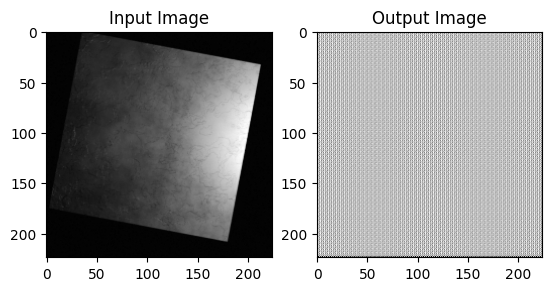

In [45]:
# One forward pass
img = train_loader.dataset[0].unsqueeze(0)
output = model(img.cuda())

print("Input shape:", images.shape)
print("Output shape:", output.shape)

# print(image[0].detach().numpy())
from matplotlib import pyplot as plt
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(images[0][0].detach().numpy(), cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Output Image')
plt.imshow(output[0][0].cpu().detach().numpy(), cmap='gray')
plt.show()

  1%|          | 1/100 [00:01<02:13,  1.35s/it]

Epoch [1/100], Loss: 0.0116, Validation Loss: 0.0114


  6%|▌         | 6/100 [00:07<01:50,  1.17s/it]

Epoch [6/100], Loss: 0.0028, Validation Loss: 0.0030


 11%|█         | 11/100 [00:12<01:43,  1.17s/it]

Epoch [11/100], Loss: 0.0008, Validation Loss: 0.0008


 16%|█▌        | 16/100 [00:18<01:37,  1.17s/it]

Epoch [16/100], Loss: 0.0005, Validation Loss: 0.0006


 21%|██        | 21/100 [00:24<01:32,  1.17s/it]

Epoch [21/100], Loss: 0.0004, Validation Loss: 0.0004


 26%|██▌       | 26/100 [00:30<01:26,  1.16s/it]

Epoch [26/100], Loss: 0.0005, Validation Loss: 0.0004


 31%|███       | 31/100 [00:36<01:20,  1.17s/it]

Epoch [31/100], Loss: 0.0003, Validation Loss: 0.0003


 36%|███▌      | 36/100 [00:42<01:14,  1.17s/it]

Epoch [36/100], Loss: 0.0003, Validation Loss: 0.0003


 41%|████      | 41/100 [00:47<01:08,  1.17s/it]

Epoch [41/100], Loss: 0.0002, Validation Loss: 0.0002


 46%|████▌     | 46/100 [00:53<01:03,  1.18s/it]

Epoch [46/100], Loss: 0.0003, Validation Loss: 0.0002


 51%|█████     | 51/100 [00:59<00:57,  1.18s/it]

Epoch [51/100], Loss: 0.0002, Validation Loss: 0.0002


 56%|█████▌    | 56/100 [01:05<00:51,  1.18s/it]

Epoch [56/100], Loss: 0.0002, Validation Loss: 0.0002


 61%|██████    | 61/100 [01:11<00:46,  1.19s/it]

Epoch [61/100], Loss: 0.0002, Validation Loss: 0.0002


 66%|██████▌   | 66/100 [01:17<00:40,  1.19s/it]

Epoch [66/100], Loss: 0.0002, Validation Loss: 0.0002


 71%|███████   | 71/100 [01:23<00:34,  1.19s/it]

Epoch [71/100], Loss: 0.0001, Validation Loss: 0.0001


 76%|███████▌  | 76/100 [01:29<00:28,  1.19s/it]

Epoch [76/100], Loss: 0.0002, Validation Loss: 0.0002


 81%|████████  | 81/100 [01:35<00:22,  1.19s/it]

Epoch [81/100], Loss: 0.0002, Validation Loss: 0.0001


 86%|████████▌ | 86/100 [01:41<00:16,  1.19s/it]

Epoch [86/100], Loss: 0.0002, Validation Loss: 0.0002


 91%|█████████ | 91/100 [01:47<00:10,  1.20s/it]

Epoch [91/100], Loss: 0.0001, Validation Loss: 0.0001


 96%|█████████▌| 96/100 [01:53<00:04,  1.19s/it]

Epoch [96/100], Loss: 0.0001, Validation Loss: 0.0001


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


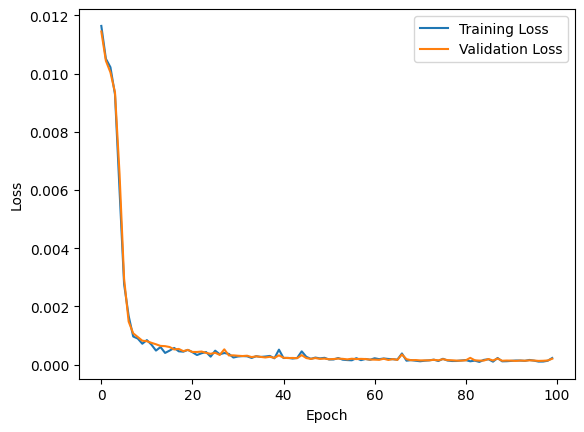

In [46]:
from tqdm import tqdm
import matplotlib.pyplot as plt
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 100
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set model to training mode
    # for img, _ in train_loader:
    for idx, img in enumerate(train_loader):
        # print('img shape:', img.shape)
        img = img.cuda()
        
        output = model(img)
        loss = criterion(output, img)

        optimizer.zero_grad() #clears the gradients of all optimized tensors.  This step is necessary because gradients are accumulated by default in PyTorch, and we want to compute fresh gradients for the current batch of data.
        loss.backward() # This line computes the gradients of the loss function with respect to the model parameters. These gradients are used to update the model parameters during optimization.
        optimizer.step() # This line updates the model parameters using the computed gradients. 
    Loss.append(loss.item())
       

    # Calculate validation loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for idx, img in enumerate(test_loader):
            img = img.cuda()
            output = model(img)
            val_loss = criterion(output, img)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Save the model
torch.save(model.state_dict(), 'autoencoder.pth')

In [48]:
with torch.no_grad():
    for idx, data in enumerate(train_loader):
        data = data.cuda()
        recon = model(data)
        break

latent_space = model.encoded
print(latent_space.shape)

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()
    

AttributeError: 'Autoencoder' object has no attribute 'encoded'

data shape: (224, 224)


<Figure size 1600x1200 with 0 Axes>

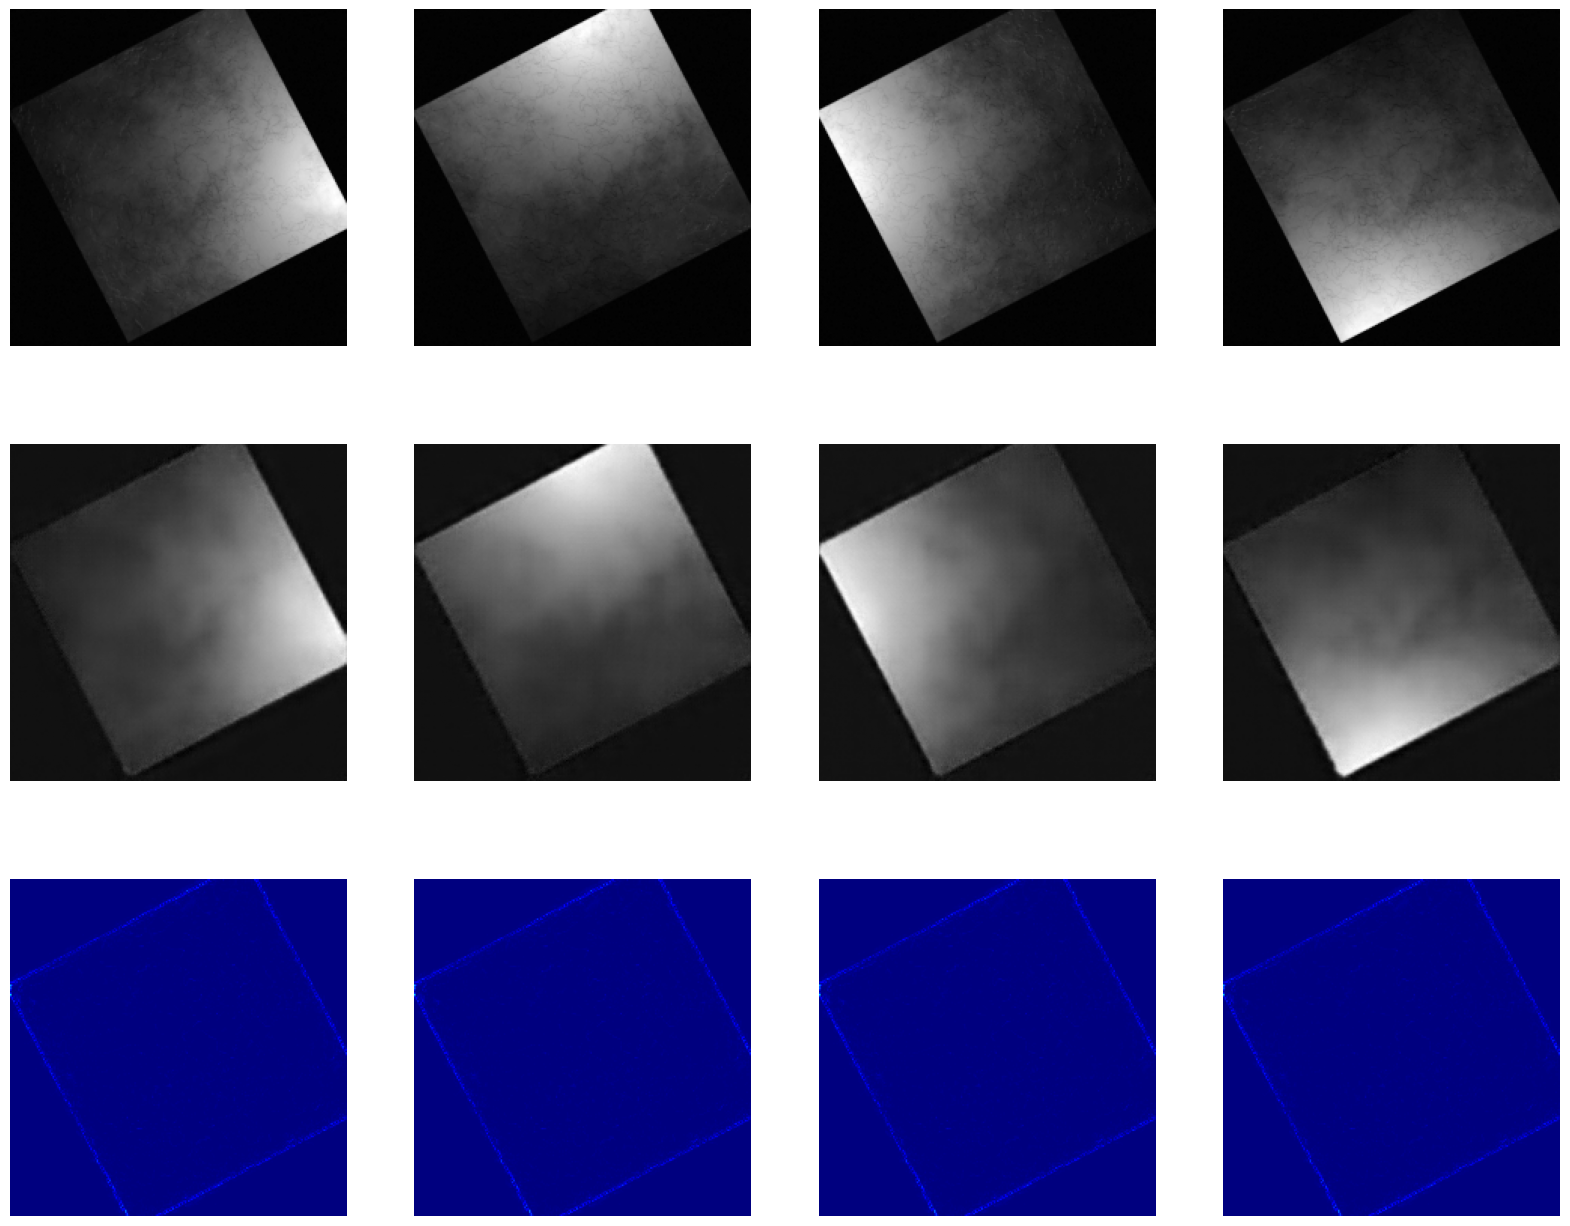

In [ ]:
# from src.hypespectral_plotter import plot_hyperspectral_image
import numpy as np
def plot_hyperspectral_image(data, recon, recon_error, title="Hyperspectral Image"):
    
    print('data shape:',data[0].shape)
    tensor = torch.tensor(data[0])
    plt.figure(dpi=250)
    fig, ax = plt.subplots(3, data.shape[0], figsize=(5*4, 4*4))
    for i in range(data.shape[0]):
        ax[0, i].imshow(data[i], cmap='gray')
        ax[1, i].imshow(recon[i], cmap='gray')
        ax[2, i].imshow(recon_error[0:-10,0:-10], cmap='jet',vmax= torch.max(torch.tensor(recon_error))) #[0:-10,0:-10]
        ax[0, i].axis('OFF')
        ax[1, i].axis('OFF')
        ax[2, i].axis('OFF')
    plt.show()

plot_hyperspectral_image(data[0].cpu().numpy(), recon[0].cpu().numpy(), recon_error[0].cpu().numpy(),
                        title='Hyperspectral Image Reconstruction Error')